In this project, your goal is to write a software pipeline to identify the lane boundaries in video from a front-facing camera on a car. The camera calibration images, test road images, and videos are available in this repository. Your job is to take what you've learned in this lesson and write a great lane-finding pipeline! Check out the project rubric for details on what's expected in your submission.

In [14]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.signal import find_peaks_cwt
%matplotlib inline

In [2]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
pattern_size = (nx, ny)
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
h, w = 0, 0

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    print('processing %s... ' % fname, end='\t')
    img = cv2.imread(fname)
    if img is None:
        print("Failed to load", fname)
        continue
        
    h, w = img.shape[:2]
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size)

    # If found, add object points, image points (after refining them)
    if ret:
        cv2.cornerSubPix(gray, corners,(5, 5),(-1, -1), criteria)
    else:
        print('chessboard not found')
        continue
    imgpoints.append(corners.reshape(-1, 2))
    objpoints.append(pattern_points)
    print('ok')
    
# Calculate camera matrix and distortion
ret, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w ,h), None, None)
print("\nRMS:", ret)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients:\n", dist_coefs.ravel())

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
print("new camera matrix:\n", new_camera_matrix)
    
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(300)
#     cv2.destroyAllWindows()

processing camera_cal/calibration11.jpg... 	ok
processing camera_cal/calibration2.jpg... 	ok
processing camera_cal/calibration14.jpg... 	ok
processing camera_cal/calibration5.jpg... 	chessboard not found
processing camera_cal/calibration7.jpg... 	ok
processing camera_cal/calibration19.jpg... 	ok
processing camera_cal/calibration8.jpg... 	ok
processing camera_cal/calibration1.jpg... 	chessboard not found
processing camera_cal/calibration17.jpg... 	ok
processing camera_cal/calibration18.jpg... 	ok
processing camera_cal/calibration15.jpg... 	ok
processing camera_cal/calibration16.jpg... 	ok
processing camera_cal/calibration20.jpg... 	ok
processing camera_cal/calibration9.jpg... 	ok
processing camera_cal/calibration10.jpg... 	ok
processing camera_cal/calibration6.jpg... 	ok
processing camera_cal/calibration3.jpg... 	ok
processing camera_cal/calibration12.jpg... 	ok
processing camera_cal/calibration13.jpg... 	ok
processing camera_cal/calibration4.jpg... 	chessboard not found

RMS: 0.8453580

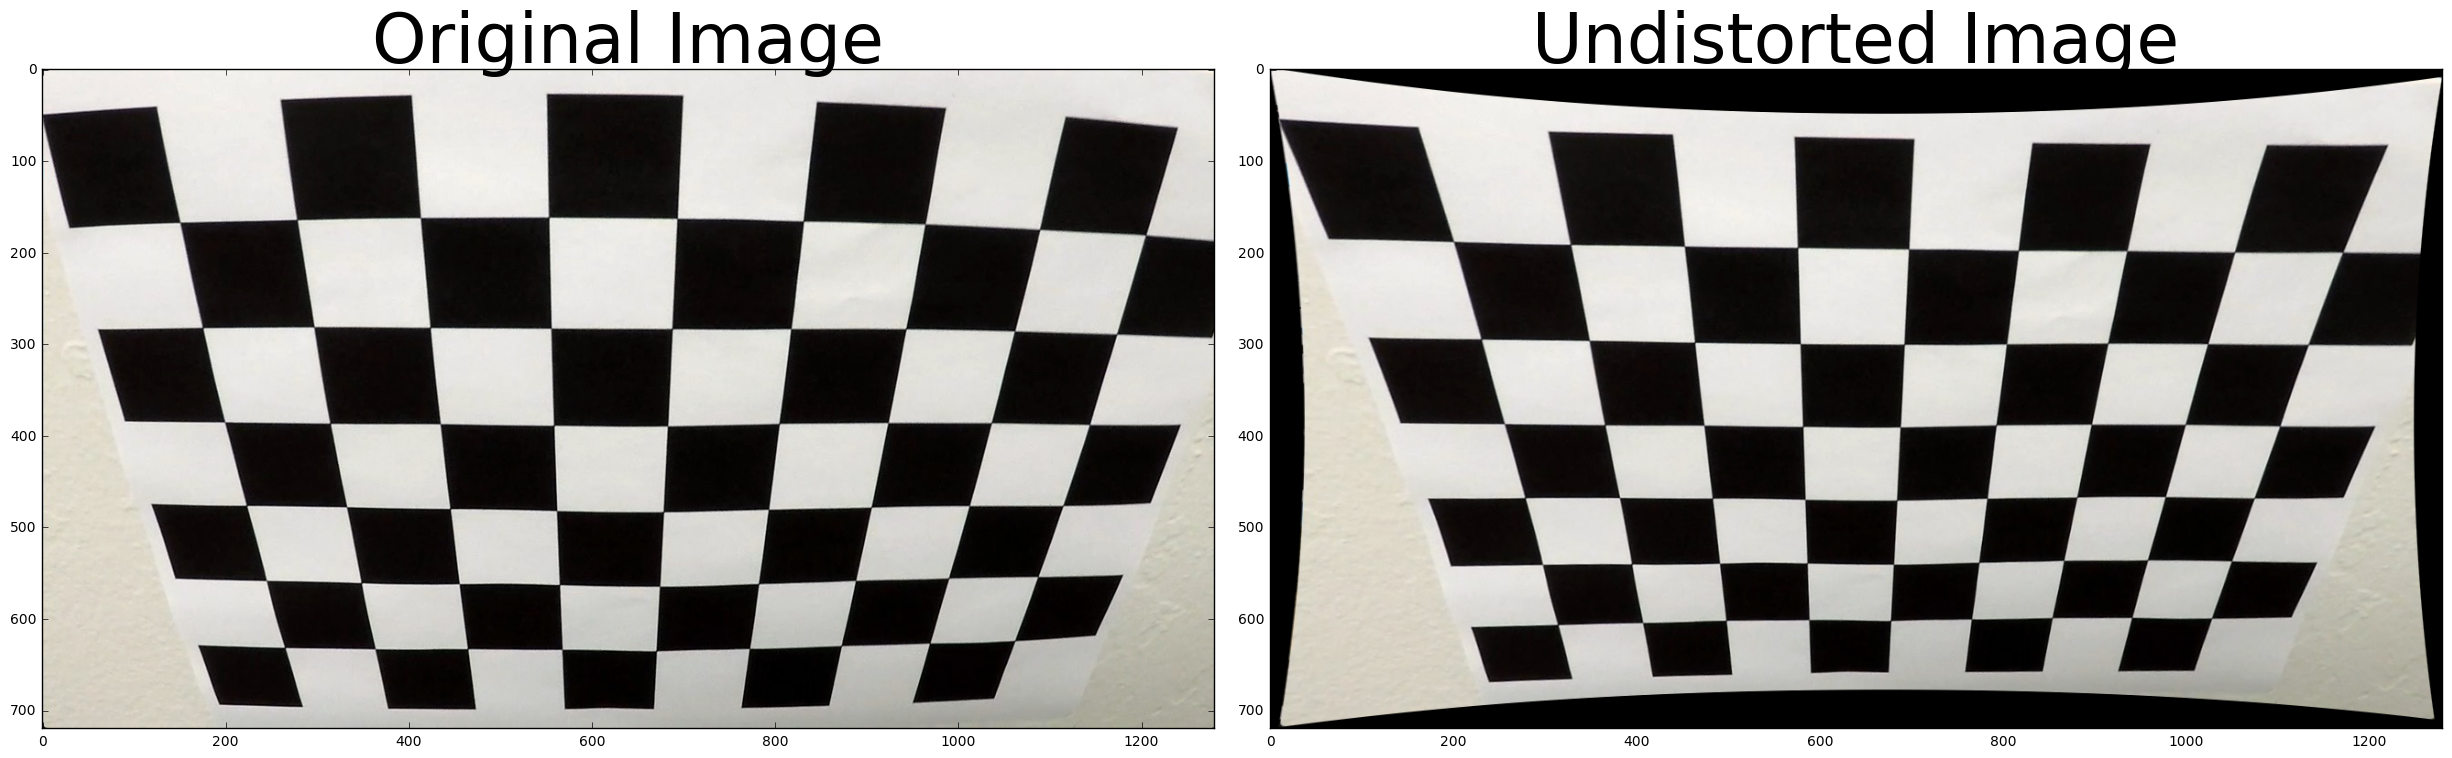

In [3]:
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, new_camera_matrix)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [58]:
def draw_lines(img, left_line, right_line, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if left_line.any():
        vx, vy, cx, cy = left_line
        w1 = (cy - img.shape[0]) / vy
        w2 = -(cy - img.shape[0] * 0.6) / vy
        cv2.line(img, (int(cx-vx*w1), img.shape[0]), (int(cx+vx*w2), int(img.shape[0] * 0.6)), color, thickness)
        
    if right_line.any():
        vx, vy, cx, cy = right_line
        w1 = (cy - img.shape[0]) / vy
        w2 = -(cy - img.shape[0] * 0.6) / vy
        cv2.line(img, (int(cx-vx*w1), img.shape[0]), (int(cx+vx*w2), int(img.shape[0] * 0.6)), color, thickness)
            
def solve_lines(lines):
    left_points = np.array([]).reshape((0,2))
    right_points = np.array([]).reshape((0,2))
    left_line = np.array([])
    right_line = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            deg = math.atan2((y2-y1), (x2-x1)) / np.pi * 180 
            #print(deg)
            
            #print(x1, y1)
            #print(x2, y2)
            
            #if (deg >= -40 and deg <= -30):    
            if (x1 < 640 and x2 < 640):
                left_points = np.vstack([left_points, (x1, y1), (x2, y2)])
            #elif ((deg >= 30 and deg <= 40)):
            elif (x1 > 640 and x2 > 640):
                right_points = np.vstack([right_points, (x1, y1), (x2, y2)])
    
    if (left_points.any()):
        left_line = cv2.fitLine(left_points, cv2.DIST_L2, 0, 0.01, 0.01)  
    if (right_points.any()):
        right_line = cv2.fitLine(right_points, cv2.DIST_L2, 0, 0.01, 0.01)  
    
    return left_line, right_line
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #use least squares to fit lines to singe left and right one
    left_line, right_line = solve_lines(lines)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, left_line, right_line, [255, 0, 0], 8)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [80]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    #undistorted = cv2.undistort(image, camera_matrix, dist_coefs, None, new_camera_matrix)
    undistorted = cv2.undistort(image, camera_matrix, dist_coefs, None, camera_matrix)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    #thresh_H = (45, 75)
    thresh_H = (15, 100)
    thresh_S = (90, 255)
    thresh_abssx = (30, 150)
    
    # Threshold color channel
    h_binary = cv2.inRange(H, thresh_H[0], thresh_H[1])
    retval, s_binary = cv2.threshold(S.astype('uint8'), thresh_S[0], thresh_S[1], cv2.THRESH_BINARY)
    
    # Combine the two binary thresholds
    combined_color_binary = np.zeros_like(h_binary)
    combined_color_binary[(h_binary == 255) & (s_binary == 255)] = 255
    
    # Grayscale image
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    sxbinary = cv2.inRange(abssx, thresh_abssx[0], thresh_abssx[1])   
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined_color_binary == 255) | (sxbinary == 255)] = 255
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = combined_binary.shape
    vertices = np.array([[(imshape[1] * 0.15, imshape[0]), (imshape[1] * 0.4, imshape[0] * 0.6),
                        (imshape[1] * 0.6, imshape[0] * 0.6), (imshape[1], imshape[0])]],
                        dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(combined_binary)   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(combined_binary, mask)
    
    #kernel = np.ones((3,3),np.uint8)
    #opening = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel)
    
    # Grab the image shape
    img_size = (masked_image.shape[1], masked_image.shape[0])
    
#     src = np.float32([[imshape[1] * 0.15, imshape[0]], 
#                       [imshape[1] * 0.4, imshape[0] * 0.6], 
#                       [imshape[1] * 0.6, imshape[0] * 0.6], 
#                       [imshape[1], imshape[0]]])
    
    src = np.float32([[0, 700], 
                      [560, 460], 
                      [720, 460], 
                      [1280, 700]])
        
    dst = np.float32([[img_size[0] / 4, img_size[1]],
                      [img_size[0] / 4, 0], 
                      [img_size[0] * 3 / 4, 0], 
                      [img_size[0] * 3 / 4, img_size[1]]])
    
    #print(src)
    #print(dst)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(masked_image, M, img_size)

    # The lane lines should appear parallel in the warped images
    # With this histogram I am adding up the pixel values along each column in the image
    
    #normalize to 0 & 1
    warped = warped / 255
    
#     histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
#     plt.plot(histogram)
#     peak = find_peaks_cwt(histogram, [100], max_distances = [100])
    
    
    # height x width = 720 x 1280
    sliding_window_num = 6
    sliding_window_height = warped.shape[0] // sliding_window_num
    # search +- 50 pixels
    sliding_window_width = 50 
    
    sliding_window_mask = np.zeros_like(warped) 
    
    for i in range(0, sliding_window_num):
        top = i * sliding_window_height
        bottom = (i + 1) * sliding_window_height
        band = warped[top:bottom, :]
        histogram = np.sum(band, axis = 0)
        plt.plot(histogram)
        #peak = find_peaks_cwt(histogram, np.arange(1, warped.shape[1]))
        peak = find_peaks_cwt(histogram, [100], max_distances = [100])
        peak_value = [histogram[index] for index in peak]
        peak_sorted = np.argsort(peak_value) 
        # reverse order
        peak_sorted = peak_sorted[::-1]

        #print(peak)
        #print(peak_value)
        
        if ((peak_sorted.shape[0] > 0) and 
            (peak[peak_sorted[0]] >= warped.shape[1] / 4) and
            (peak[peak_sorted[0]] <= warped.shape[1] * 3 /4)):
            sliding_window_mask[top:bottom, (peak[peak_sorted[0]] - sliding_window_width) : (peak[peak_sorted[0]] + sliding_window_width)] = 1
        if (peak_sorted.shape[0] > 1 and 
            peak[peak_sorted[1]] >= warped.shape[1] / 4 and
            peak[peak_sorted[1]] <= warped.shape[1] * 3 /4):
            sliding_window_mask[top:bottom, (peak[peak_sorted[1]] - sliding_window_width) : (peak[peak_sorted[1]] + sliding_window_width)] = 1
        
    warped_mask = cv2.bitwise_and(warped, sliding_window_mask)
    warped_mask = np.array(warped_mask, np.uint8)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 70 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.zeros_like(warped_mask)  # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    
    line_image = hough_lines(warped_mask, rho, theta, threshold, min_line_length, max_line_gap)
    
    warped_inv = cv2.warpPerspective(line_image, Minv, img_size)
    result = cv2.addWeighted(undistorted, 1, warped_inv, 1, 0)
    
    
    cv2.imshow('input', image)
    #cv2.imshow('output_H', h_binary)
    #cv2.imshow('output_S', s_binary)
    #cv2.imshow('output_combine_color', combined_color_binary)
    #cv2.imshow('output_grad', sxbinary)
    cv2.imshow('output_combine', combined_binary)
    #cv2.imshow('mask', mask)
    cv2.imshow('output_mask', masked_image)
    cv2.imshow('warped', warped)
    cv2.imshow('slide', sliding_window_mask)
    warped_mask = warped_mask * 255
    cv2.imshow('warped_mask', warped_mask)
    cv2.imshow('line', line_image)
    cv2.imshow('result', result)
    
    cv2.waitKey(100)
    
    #image = line_image
    #image = np.dstack(( line_image, line_image, line_image))
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    
    return result

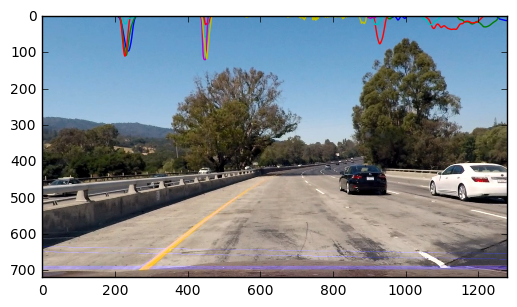

In [78]:
img = mpimg.imread('test_images/test1.jpg')
out = process_image(img)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4














  0%|          | 0/1261 [00:00<?, ?it/s]











  0%|          | 1/1261 [00:00<08:44,  2.40it/s]











  0%|          | 2/1261 [00:00<08:51,  2.37it/s]











  0%|          | 3/1261 [00:01<08:45,  2.39it/s]











  0%|          | 4/1261 [00:01<08:26,  2.48it/s]











  0%|          | 5/1261 [00:01<08:12,  2.55it/s]











  0%|          | 6/1261 [00:02<08:06,  2.58it/s]











  1%|          | 7/1261 [00:02<08:02,  2.60it/s]











  1%|          | 8/1261 [00:03<07:59,  2.61it/s]











  1%|          | 9/1261 [00:03<07:53,  2.65it/s]











  1%|          | 10/1261 [00:03<07:46,  2.68it/s]











  1%|          | 11/1261 [00:04<07:45,  2.69it/s]











  1%|          | 12/1261 [00:04<07:40,  2.71it/s]











  1%|          | 13/1261 [00:04<07:39,  2.72it/s]











  1%|          | 14/1261 [00:05<07:38,  2.72it/s]











  1%|          | 15/1261 [00:05<07:36,  2.73it/s]






























  1%|▏     

KeyboardInterrupt: 

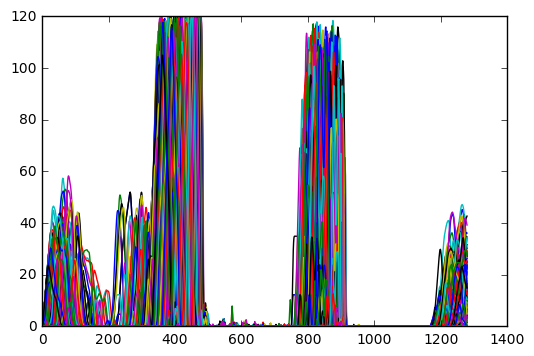

In [81]:
output_video1 = 'project_video_output.mp4'
input_video1 = VideoFileClip("project_video.mp4")
output_clip1 = input_video1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip1.write_videofile(output_video1, audio=False)

In [12]:
white_output = 'project_video_.mp4'
HTML("""
<video width="640" height="320" controls>
  <source src="{0}">
</video>
""".format(output_video1))